# Import Libraries and Load the data

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
bit_news_df = pd.read_csv('bit_news.csv')
bit_usd_df = pd.read_csv('BTCUSD_refined.csv')
bit_news_df.post_time = pd.to_datetime(bit_news_df.post_time, infer_datetime_format=True)
bit_usd_df.date = pd.to_datetime(bit_usd_df.date, infer_datetime_format=True)

# Feature Enginering

We need to clean news from unrelated to BTC titles.

In [3]:
# It's good to keep titles from CryptoMarkets and Crypto_Currency_News.
bit_news_df.post_topic.unique()

array(['investing', 'CryptoMarkets', 'economy', 'Crypto_Currency_News'],
      dtype=object)

In [4]:
# We need only rows with related to crypto.
crypto_terms = ['Bitcoin','BTC','Ethereum','ETH ','Dogecoin','DOGE ','cryptocurrency','Altcoin','$'
                'blockchain','cybercash','e-cash','digital','e-money','electronic cash','virtual','USD']
crypto_terms = [term.lower() for term in crypto_terms]

crypto_topics = ['CryptoMarkets','Crypto_Currency_News']
crypto_topics = [topic.lower() for topic in crypto_topics]

In [5]:
# Make the True/False masks and apply them.
news_mask_1 = bit_news_df.post_title.apply(lambda _title: len( [term for term in crypto_terms if (term in _title.lower())] ) > 0)
news_mask_2 = bit_news_df.post_topic.apply(lambda _topic: len( [topic for topic in crypto_topics if (topic in _topic.lower())] ) > 0)

bit_news_df = bit_news_df[news_mask_1+news_mask_2]
bit_news_df = bit_news_df.reset_index(drop=True)
bit_news_df.shape

(2068, 6)

In [6]:
bit_news_df.head()

,post_id,post_time,post_topic,post_title,post_upvotes,upvote_ratio
0,lce7o5,2021-02-04 15:03:38,CryptoMarkets,Elon Musk Sends Dogecoin To The Moon With New ...,595,0.90
1,lcjsxy,2021-02-04 19:42:31,Crypto_Currency_News,Divi Interview with Nick and NEM,39,1.00
2,ld4ypc,2021-02-05 14:06:44,CryptoMarkets,Total Market Value Of Cryptocurrencies Hits Ne...,141,0.97
3,ldcaec,2021-02-05 20:29:39,CryptoMarkets,You again ?,1108,0.98
4,ldj6hk,2021-02-06 01:33:21,Crypto_Currency_News,BITCOIN News I Krypto Friday Ep87: Masternode ...,42,0.98


In [7]:
# In case bit_usd_df.date hour: %4 != 0
# bit_usd_df = bit_usd_df.drop(index=[0,1,2])
# bit_usd_df = bit_usd_df.reset_index(drop=True)

In [8]:
# Define bit_usd_df_4h
btc_4h_df = pd.DataFrame()

# Fill new dataframe
for i, row in bit_usd_df.iterrows():
    if row.date.hour % 4 == 0:
        add_row = {'date': row.date,
                   'open': bit_usd_df.open[i-3],
                   'high': bit_usd_df.high[i-3:i+1].max(),
                   'low': bit_usd_df.low[i-3:i+1].min(),
                   'close': row.close,
                   'volume': bit_usd_df.low[i-3:i+1].sum()}
        btc_4h_df = btc_4h_df.append(add_row, ignore_index = True)

In [9]:
# Add new feature price_var
btc_4h_df['price_var'] = (btc_4h_df['close'] - btc_4h_df['open'])/btc_4h_df['open']

In [10]:
btc_4h_df.head()

,date,open,high,low,close,volume,price_var
0,2021-01-25 16:00:00,34188.20,34885.56,33616.56,33901.01,136344.59,-0.008400
1,2021-01-25 20:00:00,33901.01,34262.94,33055.00,33476.34,133618.13,-0.012527
2,2021-01-26 00:00:00,33476.34,33476.34,31775.00,32518.40,128086.22,-0.028615
3,2021-01-26 04:00:00,32518.40,32850.88,31459.59,32038.79,127412.83,-0.014749
4,2021-01-26 08:00:00,32038.79,32353.33,31149.86,31914.98,125831.07,-0.003864


Combine two dataframes in one.

In [11]:
# Bind news to specific time in bit_news_df
news_list = []
df_len = len(bit_news_df.post_time)-1

j = 0
for i, row in btc_4h_df.iterrows():
    most_liked_news = 0
    # In case there no news in the time period.
    if (bit_news_df.post_time[j] > row.date) or (j >= df_len):
        news_list.append('none')
    # We need just one news title, so if we have more than one we pick the title with more likes.
    else:
        while (bit_news_df.post_time[j] <= row.date) and (j < df_len):
            if most_liked_news == 0:
                news_list.append(bit_news_df.post_title[j])
            elif bit_news_df.post_upvotes[j] > most_liked_news:
                news_list.pop()
                news_list.append(bit_news_df.post_title[j])
            most_liked_news = max(bit_news_df.post_upvotes[j], most_liked_news)
            j += 1

# Delete everything except letters
news_list = [re.sub(r'[^A-Za-z]', ' ', item.lower()) for item in news_list]
news_list = [re.sub(' +', ' ', item.strip()) for item in news_list]
btc_4h_df['news'] = news_list
btc_4h_df['news'] = btc_4h_df['news'].replace('', 'none')

In [12]:
btc_4h_df.sample(10)

,date,open,high,low,close,volume,price_var,news
796,2021-06-07 08:00:00,36274.84,36443.40,35865.32,36120.96,143953.86,-0.004242,none
1351,2021-09-07 20:00:00,47514.82,47624.58,46010.01,46829.37,185559.12,-0.014426,none
1990,2021-12-23 08:00:00,48378.74,48579.18,48072.35,48366.20,192748.76,-0.000259,none
837,2021-06-14 04:00:00,39116.28,39816.72,38766.15,39278.50,155452.31,0.004147,none
487,2021-04-16 20:00:00,61817.74,62101.32,61226.46,62015.25,246100.08,0.003195,dread it run from it doge still arrives
1755,2021-11-14 04:00:00,65000.46,65102.38,64560.11,64743.14,258537.50,-0.003959,none
1775,2021-11-17 12:00:00,59593.62,60831.30,58434.80,60500.01,238066.11,0.015210,telos evm mainnet goes live the evm allows the...
1275,2021-08-26 04:00:00,49311.99,49358.05,47622.88,47886.93,192880.69,-0.028899,none
1919,2021-12-11 12:00:00,48410.20,48647.17,48166.08,48564.71,192977.20,0.003192,mecca of mining brazil considers zero tax on g...
731,2021-05-27 12:00:00,38886.24,39969.60,38875.38,39350.29,156590.10,0.011934,very promising new crypto coin hakunamatata


## Visulising the BTC-USD

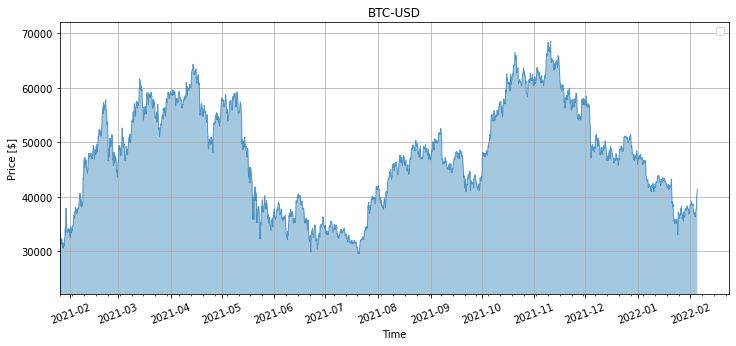

In [13]:
plt.figure(figsize=(12,5))
plt.plot_date(x=btc_4h_df.date, y=btc_4h_df.close, label='BTC-USD',
              linestyle='solid', linewidth=1, markersize=0,
              fillstyle='none', alpha=0.7
)

plt.fill_between(x=btc_4h_df.date, y1=btc_4h_df.close, alpha=0.4)
plt.plot()

plt.title('BTC-USD')
plt.xlabel('Time')
plt.ylabel(r'Price [\$]')
plt.legend('')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_minor_locator(mdates.WeekdayLocator())
plt.grid(True)

plt.xlim(btc_4h_df.date.min(),)
plt.ylim(np.ceil(btc_4h_df.close.min()*0.75),)

plt.xticks(rotation=20)
plt.show()

And the last thing is creating trend (up/down) column for classification task.

In [14]:
# We will see how news impact the price on 30*4-hour horizon.
for i in range(len(btc_4h_df)):
    btc_4h_df.loc[i,'trend'] = (btc_4h_df.loc[i+30,'close']-btc_4h_df.loc[i,'close'] > 0).astype(int)
    if i >= len(btc_4h_df) - 31: break

## Save the final dataframe to .csv file

In [15]:
pd.DataFrame(btc_4h_df).to_csv('BTC_Finale.csv', index=False)